# Thực hiện đọc dữ liệu từ hdfs

Dữ liệu đã được lưu trữ trên hdfs, hiện tại ta cần sử dụng pyspark để đọc dữ liệu ra và xử lý. Cụm spark đã được bật, ta có thể xem thông tin của cả cụm trên web ui host post của spark-master là 0.0.0.0:8080 (truy cập qua localhost) hoặc 172.19.0.2:8080 (truy cập qua ip của container trong docker, xem thông tin bằng lệnh docker network inspect).

In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from IPython.display import Image

In [2]:
spark = SparkSession.builder.master("spark://spark-master:7077").appName("Stock_price_analysis").getOrCreate()

Ta có thể  truy cập vào địa chỉ web ui của spark-master để xem thông tin của chương trình đang chạy

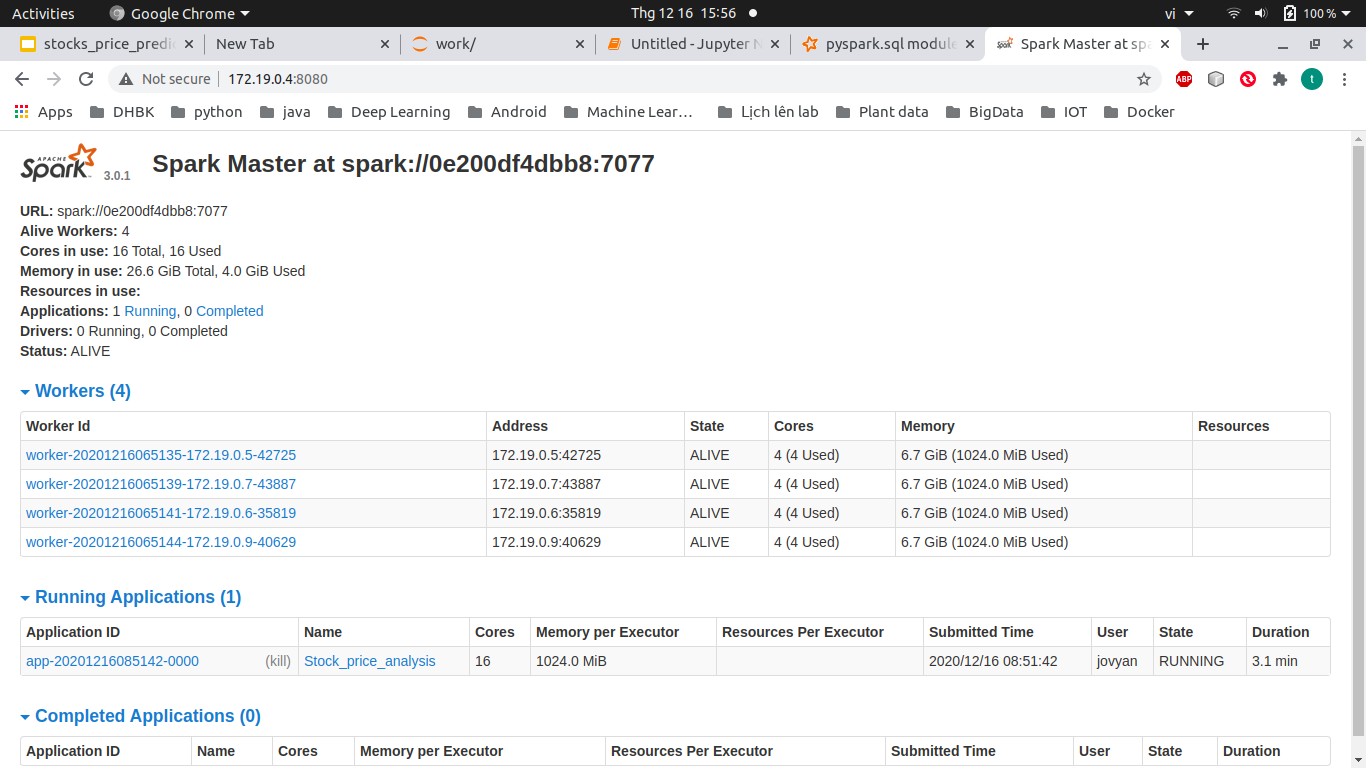

In [3]:
Image("spark_app.png")

Tiếp theo ta sẽ sử dụng spark session vừa tạo để truy cập vào hdfs và lấy dữ liệu ra để xử lý. Cụ thể ta sẽ truy cập vào địa chỉ của namenode trên hdfs là namenode:9000 

# Một số phân tích cơ bản

Ta lấy dữ liệu dataframe từ spark như thông thường.

Ở đây ta so sánh dữ liệu chứng khoán của 5 công ty lớn:

#### VinGroup JIC (mã VIC)

#### Vinamilk (mã VNM)

#### Vietcombank (mã VCB)

#### Hòa Phát Group (mã HPG)

#### Chứng Khoán SSI (mã SSI)


In [4]:
df_VIC = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000//user/root/vn_stock/vn_stock/data-20251018T162450Z-1-001/data/stock_data_VIC.csv")

df_VNM = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000//user/root/vn_stock/vn_stock/data-20251018T162450Z-1-001/data/stock_data_VNM.csv")

df_VCB = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000//user/root/vn_stock/vn_stock/data-20251018T162450Z-1-001/data/stock_data_VCB.csv")

df_HPG = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000//user/root/vn_stock/vn_stock/data-20251018T162450Z-1-001/data/stock_data_HPG.csv")

df_SSI = spark.read.format("csv").option("header", "true")\
.option("inferSchema", "true").load("hdfs://namenode:9000//user/root/vn_stock/vn_stock/data-20251018T162450Z-1-001/data/stock_data_SSI.csv")

Sau khi lấy dữ liệu, ta thực hiện việc thêm cột Mean để tìm trung bình của mã chứng khoán trong ngày.

Từ đó ta vẽ được biểu đồ để so sánh các mã chứng khoán.

In [5]:
from pyspark.sql.functions import year, expr

df_VICmean = df_VIC.withColumn("Mean", expr('(High+Low)/2'))
df_VNMmean = df_VNM.withColumn("Mean", expr('(High+Low)/2'))
df_VCBmean = df_VCB.withColumn("Mean", expr('(High+Low)/2'))
df_HPGmean = df_HPG.withColumn("Mean", expr('(High+Low)/2'))
df_SSImean = df_SSI.withColumn("Mean", expr('(High+Low)/2'))

Để dễ sử dụng thư viện đồ thị matplotlib, ta chuyển các dữ liệu dataframes về dạng pandas.

In [6]:
df_VICmean = df_VICmean.toPandas()
df_VNMmean = df_VNMmean.toPandas()
df_VCBmean = df_VCBmean.toPandas()
df_HPGmean = df_HPGmean.toPandas()
df_SSImean = df_SSImean.toPandas()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/usr/local/spark/python/pysp

Kết quả so sánh chỉ số trung bình trong ngày của các mã nói trên trong đồ thị

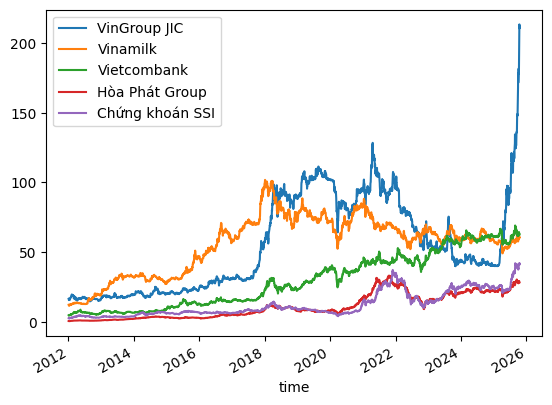

In [9]:
ax = df_VICmean.plot(x='time', y= 'Mean', label='VinGroup JIC')
ax = df_VNMmean.plot(ax=ax, x= 'time', y= 'Mean',label='Vinamilk')
ax = df_VCBmean.plot(ax=ax, x= 'time', y= 'Mean',label='Vietcombank')
ax = df_HPGmean.plot(ax=ax, x= 'time', y= 'Mean',label='Hòa Phát Group')
df_SSImean.plot(ax=ax, x= 'time', y= 'Mean',label='Chứng khoán SSI')
plt.savefig('stock_price_prediction.png', dpi=300, bbox_inches='tight')

Ta đánh giá sự thay đổi của các mã của các công ty Facebook, Alibaba và Zoom trên theo ngày (tính theo %) (Apple và Cloudfare ta không xét do thời gian quá lớn hoặc quá nhỏ)

In [10]:
df_VICmean['Change']= (df_VICmean['close']/df_VICmean['close'].shift(1)) - 1 
df_VNMmean['Change']= (df_VNMmean['close']/df_VNMmean['close'].shift(1)) - 1 
df_VCBmean['Change']= (df_VCBmean['close']/df_VCBmean['close'].shift(1)) - 1 
df_HPGmean['Change']= (df_HPGmean['close']/df_HPGmean['close'].shift(1)) - 1 
df_SSImean['Change']= (df_SSImean['close']/df_SSImean['close'].shift(1)) - 1 

Sau đó, ta vẽ biểu đồ cột thể hiện sự thay đổi của các mã theo ngày

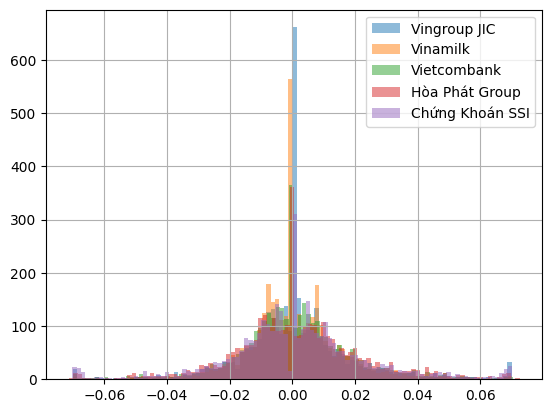

In [11]:
df_VICmean['Change'].hist(bins=100, label='Vingroup JIC',alpha=0.5)
df_VNMmean['Change'].hist(bins=100, label='Vinamilk', alpha=0.5)
df_VCBmean['Change'].hist(bins=100, label='Vietcombank', alpha=0.5)
df_HPGmean['Change'].hist(bins=100, label='Hòa Phát Group', alpha=0.5)
df_SSImean['Change'].hist(bins=100, label='Chứng Khoán SSI', alpha=0.5)
plt.legend()
plt.savefig('stock_price_hist.png', dpi=300, bbox_inches='tight')

Biểu đồ trên thể hiện sự biến động của từng mã. Số lượng gần 0 càng nhiều chứng tỏ là mã càng biến động ít và ngược lại.

Ta vẽ biểu đồ đường để miêu tả rõ hơn điều đó

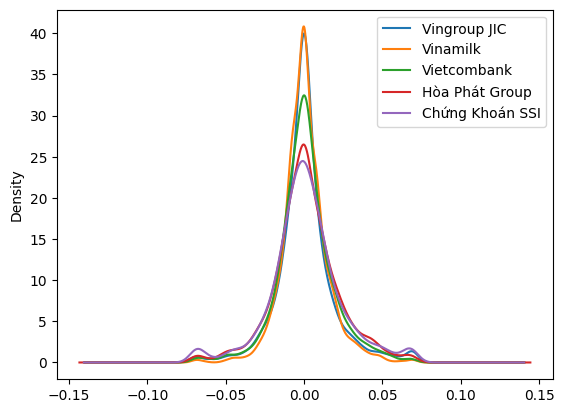

In [12]:
df_VICmean['Change'].plot(kind= 'kde', label = 'Vingroup JIC')
df_VNMmean['Change'].plot(kind= 'kde', label = 'Vinamilk')
df_VCBmean['Change'].plot(kind= 'kde', label = 'Vietcombank')
df_HPGmean['Change'].plot(kind= 'kde', label = 'Hòa Phát Group')
df_SSImean['Change'].plot(kind= 'kde', label = 'Chứng Khoán SSI')
plt.legend()
plt.savefig('stock_price_kde.png', dpi=300, bbox_inches='tight')

Từ biểu đồ trên, ta thấy sự biến động của các mã đều gần giống với phân phối chuẩn có giá trị trung bình là 0.

# Dùng mô hình học máy để dự đoán tình hình chứng khoán

Trong phần này chúng em sẽ tính giá trị trung bình của cổ phiếu công ty Gabelli Equity Trust Inc (mã là GAB). Rồi sử dụng một mô hình học máy đơn giản để dự đoán giá cổ phiếu trung bình của công ty. Chúng em dùng các thông tin từ trước năm 2020 cho việc training và thông tin của năm 2020 cho việc testing.

In [13]:
df = spark.read.format("csv")\
.option("header", "true")\
.option("inferSchema", "true")\
.load("hdfs://namenode:9000//user/root/vn_stock/vn_stock/data-20251018T162450Z-1-001/data/stock_data_CII.csv")

In [14]:
df.show(5)

+---+-------------------+----+----+----+-----+------+
|_c0|               time|open|high| low|close|volume|
+---+-------------------+----+----+----+-----+------+
|  0|2012-01-03 00:00:00|7.16|7.63|7.02| 7.09|167760|
|  1|2012-01-04 00:00:00|7.26|7.26|6.89| 6.92|113790|
|  2|2012-01-05 00:00:00|6.85|7.09|6.85| 6.89|  4950|
|  3|2012-01-06 00:00:00|7.12|7.12|6.62| 6.62| 34040|
|  4|2012-01-09 00:00:00|6.58|6.79|6.58| 6.75| 15850|
+---+-------------------+----+----+----+-----+------+
only showing top 5 rows



In [15]:
from pyspark.sql.functions import expr, col, column
df = df.withColumn("Mean", expr('(High+Low)/2'))  #Thêm một cột giá trị mean ( được tính bằng trung bình của low và high)

In [16]:
df.show(5)

+---+-------------------+----+----+----+-----+------+------------------+
|_c0|               time|open|high| low|close|volume|              Mean|
+---+-------------------+----+----+----+-----+------+------------------+
|  0|2012-01-03 00:00:00|7.16|7.63|7.02| 7.09|167760| 7.324999999999999|
|  1|2012-01-04 00:00:00|7.26|7.26|6.89| 6.92|113790| 7.074999999999999|
|  2|2012-01-05 00:00:00|6.85|7.09|6.85| 6.89|  4950|              6.97|
|  3|2012-01-06 00:00:00|7.12|7.12|6.62| 6.62| 34040|              6.87|
|  4|2012-01-09 00:00:00|6.58|6.79|6.58| 6.75| 15850|6.6850000000000005|
+---+-------------------+----+----+----+-----+------+------------------+
only showing top 5 rows



In [17]:
asc_df = df.sort(df.time.asc()) #Sắp xếp các cột theo tứ tự tăng dần của thời gian

In [18]:
asc_df.show(5)

+---+-------------------+----+----+----+-----+------+------------------+
|_c0|               time|open|high| low|close|volume|              Mean|
+---+-------------------+----+----+----+-----+------+------------------+
|  0|2012-01-03 00:00:00|7.16|7.63|7.02| 7.09|167760| 7.324999999999999|
|  1|2012-01-04 00:00:00|7.26|7.26|6.89| 6.92|113790| 7.074999999999999|
|  2|2012-01-05 00:00:00|6.85|7.09|6.85| 6.89|  4950|              6.97|
|  3|2012-01-06 00:00:00|7.12|7.12|6.62| 6.62| 34040|              6.87|
|  4|2012-01-09 00:00:00|6.58|6.79|6.58| 6.75| 15850|6.6850000000000005|
+---+-------------------+----+----+----+-----+------+------------------+
only showing top 5 rows



In [19]:
from pyspark.sql.functions import year
df_test = asc_df.filter(year("time") > 2023) #tách ra tập test là tập gồm thông tin của năm 2021

In [20]:
df_test.show(5)

+----+-------------------+-----+-----+-----+-----+--------+------------------+
| _c0|               time| open| high|  low|close|  volume|              Mean|
+----+-------------------+-----+-----+-----+-----+--------+------------------+
|2996|2024-01-02 00:00:00|13.84|13.96|13.56|13.64| 5962764|13.760000000000002|
|2997|2024-01-03 00:00:00|13.64|14.04|13.52|13.88|10159195|             13.78|
|2998|2024-01-04 00:00:00| 14.0| 14.0|13.72|13.72|10052421|             13.86|
|2999|2024-01-05 00:00:00| 13.8|13.84|13.52|13.56| 8545576|             13.68|
|3000|2024-01-08 00:00:00|13.88|14.47|13.88|14.47|26204153|            14.175|
+----+-------------------+-----+-----+-----+-----+--------+------------------+
only showing top 5 rows



In [21]:
df_train = asc_df.subtract(df_test)   #tách ra tập train
df_train.count()

2996

In [22]:
df_train = df_train.sort(df_train.time.asc())   #sắp xếp lại tập train
df_train.show(5)

+---+-------------------+----+----+----+-----+------+------------------+
|_c0|               time|open|high| low|close|volume|              Mean|
+---+-------------------+----+----+----+-----+------+------------------+
|  0|2012-01-03 00:00:00|7.16|7.63|7.02| 7.09|167760| 7.324999999999999|
|  1|2012-01-04 00:00:00|7.26|7.26|6.89| 6.92|113790| 7.074999999999999|
|  2|2012-01-05 00:00:00|6.85|7.09|6.85| 6.89|  4950|              6.97|
|  3|2012-01-06 00:00:00|7.12|7.12|6.62| 6.62| 34040|              6.87|
|  4|2012-01-09 00:00:00|6.58|6.79|6.58| 6.75| 15850|6.6850000000000005|
+---+-------------------+----+----+----+-----+------+------------------+
only showing top 5 rows



In [23]:
dataset_train = df_train.toPandas()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [24]:
# Import những thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
from os import path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
# Thuc hien scale du lieu gia ve khoang 0,1
training_set = dataset_train[['close']].values
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

Tạo dữ liệu train, X = 60 time steps, Y =  1 time step, có nghĩa lấy dữ liệu của 60 ngày trước để dự đoán cho ngày tiếp theo hay có thể hiểu là lấy 60 ngày trước làm đầu vào, và đầu ra của mô hình sẽ là ngày tiếp theo

In [27]:
# Tạo dữ liệu train 
X_train = []
y_train = []
no_of_sample = len(training_set)

for i in range(60, no_of_sample):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [28]:
# Xây dựng model LSTM
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [29]:
# Nếu tồn tại model thì load lại nếu không thì thực hiện train 
if path.exists("mymodel.h5"):
    regressor.load_weights("mymodel.h5")
else:
    regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
    regressor.save("mymodel.h5")

In [30]:
dataset_test = df_test.toPandas()
real_stock_price = dataset_test["close"].values

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [31]:
# Tiến hành dự đoán 
dataset_total = pd.concat((dataset_train['Mean'], dataset_test['Mean']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
no_of_sample = len(inputs)

for i in range(60, no_of_sample):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

/tmp/ipykernel_473/495611032.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values


14/14 [==============================] - 1s 19ms/step


In [32]:
# kiểm tra model đã load/được train chưa
try:
    print("Model summary:")
    regressor.summary()
except Exception as e:
    print("Model chưa sẵn sàng:", e)

# kiểm tra shapes
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)

# kiểm tra scaler và vài giá trị
print("Scaler data min/max (train):", sc.data_min_, sc.data_max_)
print("Sample inputs (scaled) first 5:", inputs[:5].ravel())
# predict thử và in
pred = regressor.predict(X_test[:5])
print("raw predict (first 5):", pred.ravel())
print("after inverse transform:", sc.inverse_transform(pred)[:5].ravel())


Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)  

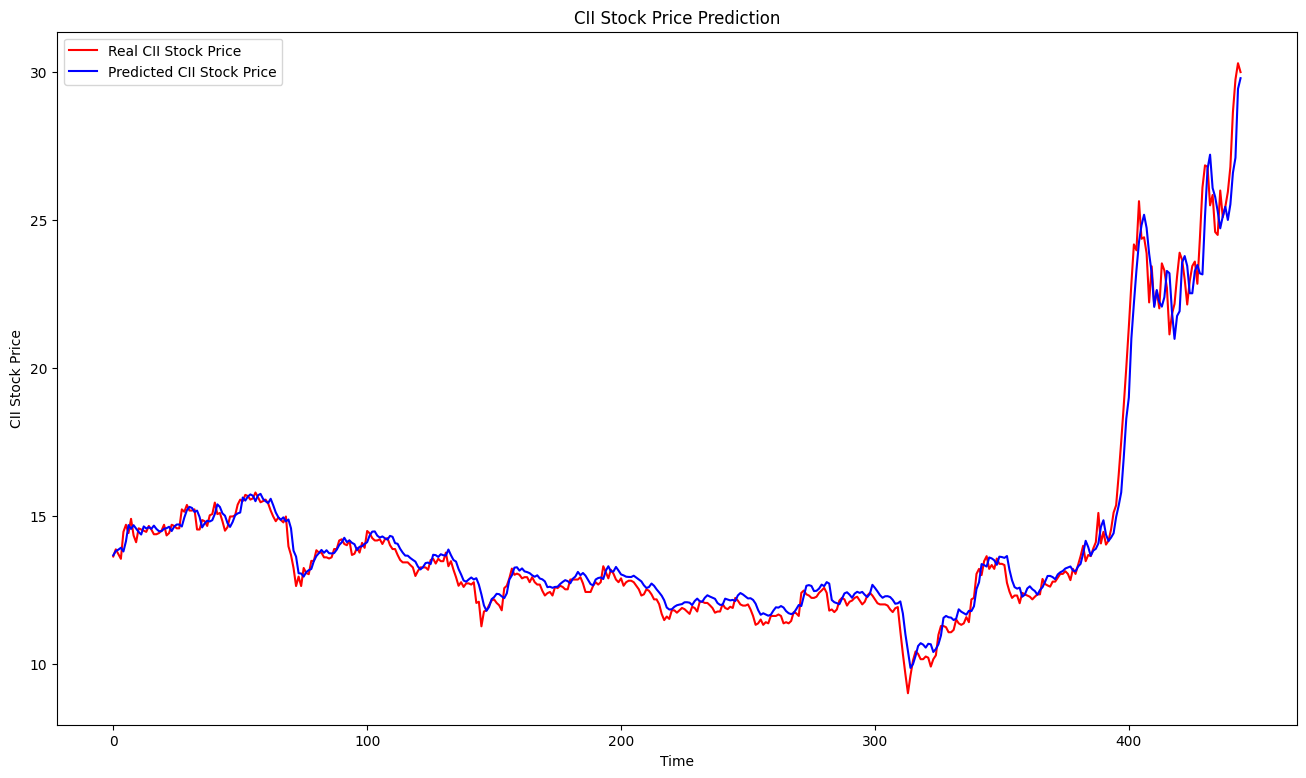

<Figure size 640x480 with 0 Axes>

In [33]:
# Ve bieu do gia that va gia du doan
plt.figure(figsize=(16,9))
plt.plot(real_stock_price, color = 'red', label = 'Real CII Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted CII Stock Price')
plt.title('CII Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('CII Stock Price')
plt.legend()
plt.show()
plt.savefig('stock_CII_price_prediction.png', dpi=300, bbox_inches='tight')

In [34]:
spark.stop()

In [ ]:
Image("spark_st.png")